In [205]:
import cv2 as cv
import matplotlib.pyplot as plt
from numpy import *
from skimage.color import rgb2hed, hed2rgb,separate_stains, combine_stains
from skimage.exposure import rescale_intensity
from matplotlib.colors import LinearSegmentedColormap
from skimage import data
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D #--- For 3D plot
#https://github.com/scikit-image/scikit-image/blob/0e8cff47a533e240508e2485032dac78220ac6c9/skimage/color/colorconv.py#L1375

## 定义工具函数

In [206]:
def norm_by_row(M):
    for k in range(M.shape[1]):
        M[k,:] /= np.sqrt(np.sum(np.power(M[k,:],2)))
    return M

def showbychan(im_ihc):
    for k in range(3):
        plt.figure()
        plt.imshow(im_ihc[:, :, k], cmap="gray")
        
def rgbdeconv(rgb, conv_matrix, C=0):
    rgb = rgb.copy().astype(float)
    rgb += C
    print(rgb.shape)
    print(np.reshape(-np.log10(rgb), (-1, 3)).shape)
    stains = np.reshape(-np.log10(rgb), (-1, 3)) @ conv_matrix
    return np.reshape(stains, rgb.shape)

def hecconv(stains, conv_matrix, C=0):
#     from skimage.exposure import rescale_intensity
    stains = stains.astype(float)
    logrgb2 = -np.reshape(stains, (-1, 3)) @ conv_matrix
    rgb2 = np.power(10, logrgb2)
    return np.reshape(rgb2 - C, stains.shape)

def surf(matIn, name="fig", div = (50, 50), SIZE = (8, 6)):
    x = np.arange(0, matIn.shape[0])
    y = np.arange(0, matIn.shape[1])
    x, y = np.meshgrid(y, x)
    fig = plt.figure(figsize = SIZE)
    ax = Axes3D(fig)
    ax.plot_surface(x, y, matIn, rstride=div[0], cstride=div[1], cmap='jet')
    plt.title(name)
    plt.show()
    
def in_range(d):
    return (0, np.max(cv.GaussianBlur(d.copy(), (3,3), 0)))

## 读取文件/常量定义

Trans. H.E [[ 0.65    0.7     0.29  ]
 [ 0.07    0.99    0.11  ]
 [-0.2101 -0.0512  0.5945]]
Trans. Ki67 [[ 0.65    0.7     0.29  ]
 [ 0.3807 -0.4287  0.1815]
 [ 0.27    0.57    0.78  ]]


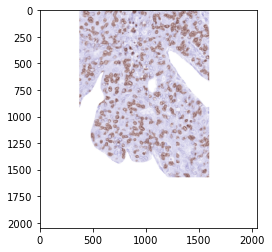

In [644]:
H_DAB = array([
    [0.65,0.70,0.29],
    [0.07, 0.99, 0.11],
    [0.27,0.57,0.78]
])

H_Mou = H_DAB.copy()
H_Mou[2,:] = np.cross(H_DAB[0,:], H_DAB[1,:])

H_ki67 = H_DAB.copy()
H_ki67[1,:] = np.cross(H_DAB[0,:], H_DAB[2,:])

im_hex = cv.imread("/Users/cunyuan/DATA/ji1024_orig/4d/val1024/chips/13hepatches.tif", cv.CV_32F)
im_ki67 = cv.imread("/Users/cunyuan/DATA/ji1024_orig/4d/val1024/dab/ki67patches13.tif", cv.CV_32F)

im_hex = cv.imread("/Users/cunyuan/DATA/Kimura/qupath-proj/tiles/01_17-7930_Ki67_HE_1024.0_1.0/53_01_17-7930_Ki67_HE (d=1.0, x=25360.0, y=88432.0, w=1024.0, h=1024.0, z=53).tif", cv.CV_32F)
im_ki67 = cv.imread("/Users/cunyuan/DATA/Kimura/qupath-proj/tiles/01_17-7930_Ki67_IHC_1024.0_1.0/53_01_17-7930_Ki67_IHC (d=1.0, x=25360.0, y=88432.0, w=1024.0, h=1024.0, z= 53).tif", cv.CV_32F)

im_hex = cv.imread("/Users/cunyuan/DATA/Kimura/qupath-proj/tiles/0.36/results/200/2502/he_seq_0c.tif")
im_ki67 = cv.imread("/Users/cunyuan/DATA/Kimura/qupath-proj/tiles/0.36/results/200/2502/test_seq_0c.tif")

im_mask = cv.cvtColor(cv.imread("/Users/cunyuan/DATA/ji1024_orig/4d/val1024/masks/13hepatches_mask.tif",
                                cv.CV_32F), cv.COLOR_BGR2GRAY)

im_hex = cv.cvtColor(im_hex, cv.COLOR_BGR2RGB)/255.
im_ki67 = cv.cvtColor(im_ki67, cv.COLOR_BGR2RGB)/255.

cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['white','darkviolet'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white','saddlebrown'])
cmap_res = LinearSegmentedColormap.from_list('mycmap', ['white','green'])
print("Trans. H.E", H_Mou)
print("Trans. Ki67", H_ki67)
plt.imshow(im_ki67)

## 实验：染色解组

(2048, 2048, 3)
(4194304, 3)


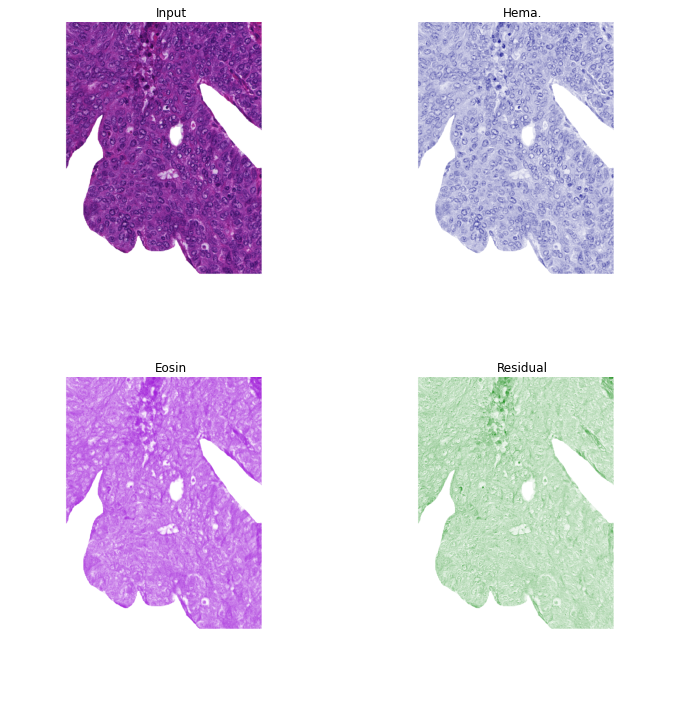

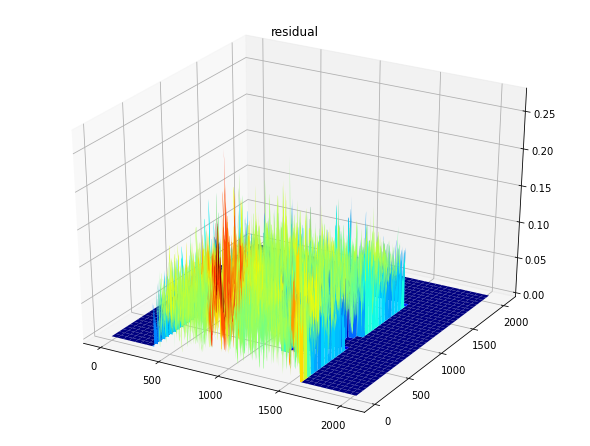

In [645]:
H = H_Mou
Hinv = linalg.inv(norm_by_row(H))

img = im_hex
img[img==0] = 1E-6
im_sepa_hex=abs(rgbdeconv(img, Hinv))
h = im_sepa_hex[:,:,0];e = im_sepa_hex[:,:,1];d_r = im_sepa_hex[:,:,2];

fig = plt.figure(figsize=(10,10));
plt.subplot(221);plt.imshow(img);plt.title("Input");plt.axis('off')
axis=plt.subplot(222);plt.imshow(rescale_intensity(h, in_range=in_range(h)), cmap=cmap_hema);plt.title("Hema."),plt.axis('off')
plt.subplot(223);plt.imshow(rescale_intensity(e, in_range=in_range(e)), cmap=cmap_eosin);plt.title("Eosin");plt.axis('off')
plt.subplot(224);plt.imshow(rescale_intensity(d_r, in_range=in_range(d_r)), cmap=cmap_res);plt.title("Residual");plt.axis('off')
fig.tight_layout()
# print(im_sepa_hex)

surf(d_r, "residual", div=(50,50))

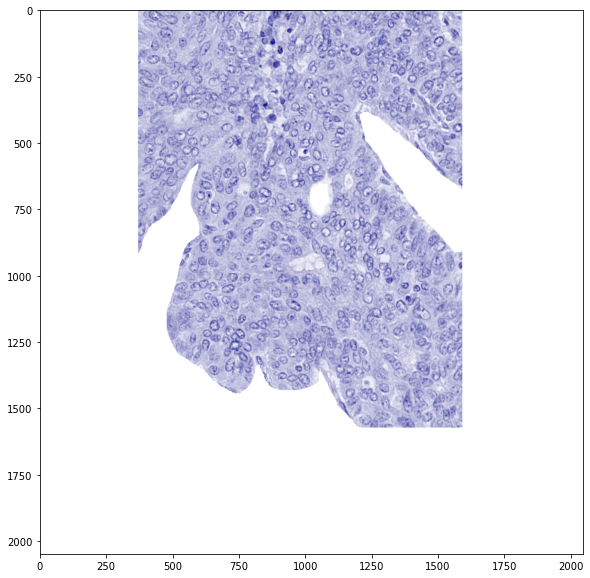

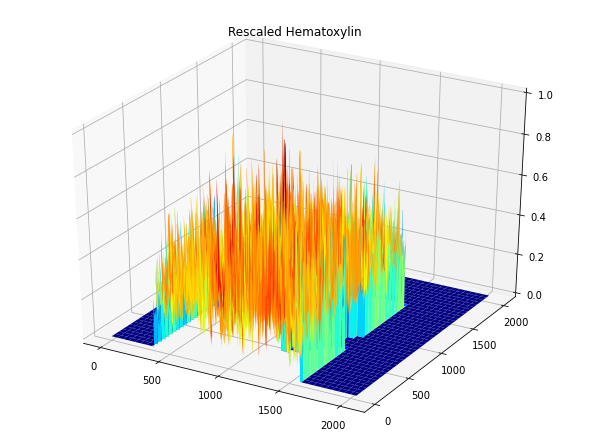

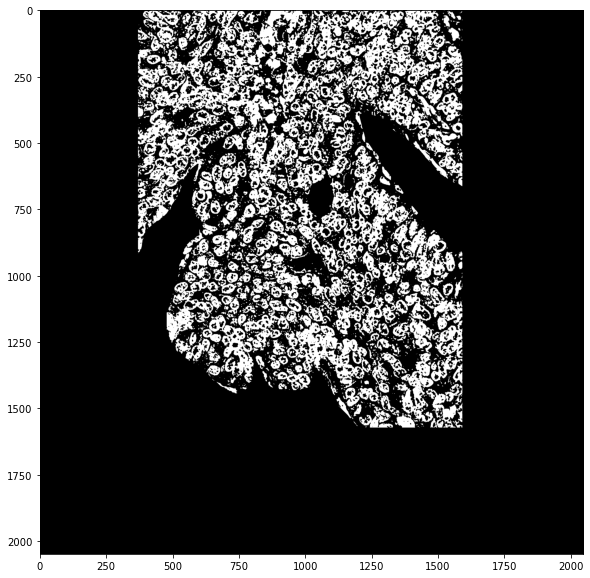

In [646]:
h1 = rescale_intensity(h, in_range=in_range(h))
plt.figure(figsize=(10,10));plt.imshow(h1, cmap=cmap_hema)
surf(h1, "Rescaled Hematoxylin")
plt.figure(figsize=(10,10));plt.imshow(h1>0.3, cmap="gray")

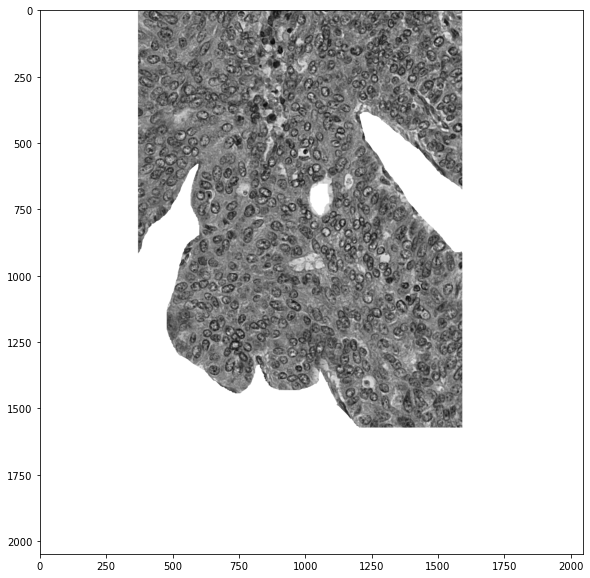

In [647]:
img_r = img[:,:,0]
plt.figure(figsize=(10,10));plt.imshow(img_r, cmap="gray")

(-0.5, 2047.5, 2047.5, -0.5)

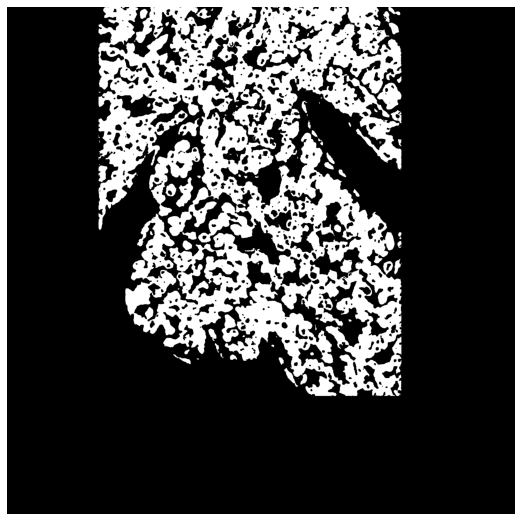

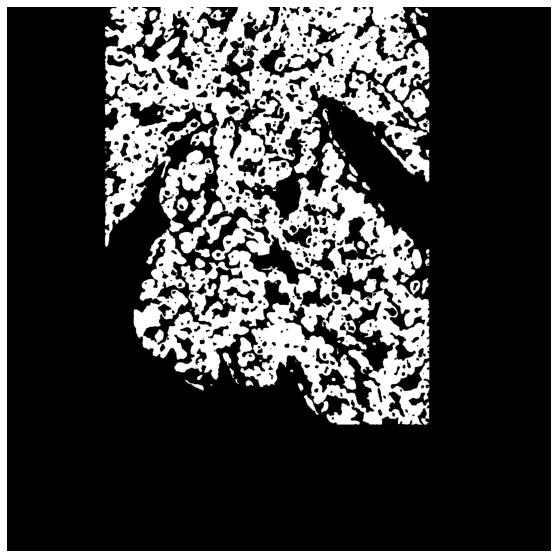

In [648]:
from cv2 import ximgproc
def gfLabel(img_r, mode=-1, hard_thresh=0.5, geps=1000, grad=5,
           MOP_SIZE=3, MCL_SIZE=3, MORPH_ITER=2):
    img_r = rescale_intensity(img_r, in_range=in_range(img_r))
    d1 = img_r
    d2 = (d1*255).astype(uint8)
    
    d2 = cv.morphologyEx(d2, op=cv.MORPH_OPEN, kernel=np.ones((MOP_SIZE,MOP_SIZE), uint8), iterations = MORPH_ITER)
#     d2 = cv.morphologyEx(d2, op=cv.MORPH_CLOSE, kernel=np.ones((MCL_SIZE, MCL_SIZE), uint8), iterations=MORPH_ITER)

    guidedDAB = ximgproc.guidedFilter(guide=d2, src=d2, radius=grad, eps=geps, dDepth=-1)

    if mode==-1:
        d1 *= (guidedDAB < (hard_thresh*255))
        # _, _d1 = cv.threshold(guidedDAB,25,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
        # d1 = (guidedDAB/255)*(_d1/255)
        d2 = (d1*255).astype(uint8)
    else:
        d1 *= (guidedDAB > (hard_thresh*255))
        d2 = (d1*255).astype(uint8)
    guide = d2

    guidedDAB = ximgproc.guidedFilter(guide=guide, src=d2, radius=grad, eps=geps, dDepth=-1)

    _,guidedDAB = cv.threshold((guidedDAB).astype(uint8),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    guidedDAB = ((guidedDAB) > 0).astype(uint8)
    plt.figure(figsize=(20,10));plt.subplot(121);plt.imshow(guidedDAB, cmap = "gray");plt.axis('off')

    return guidedDAB

guidedDAB = gfLabel(img_r)
plt.figure(figsize=(10,10));plt.imshow(guidedDAB, cmap = "gray");plt.axis('off')

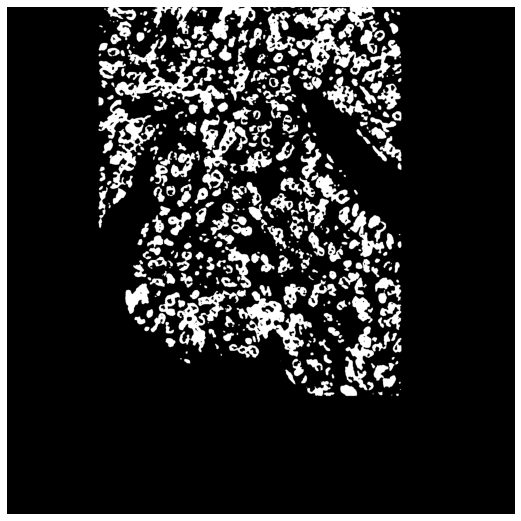

In [671]:
im_mask =gfLabel(h, mode=1, hard_thresh = 0.3)

## 实验：细胞分割

In [672]:
idx= 10
im_he = im_hex.copy()
im_ihc = im_ki67.copy()

thresh = im_mask

# noise removal
kernel = np.ones((3,3),np.uint8)
# opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 10)
opening = thresh
# sure background area
sure_bg = np.uint8(cv.dilate(opening,kernel,iterations=5))

# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,3)
ret, sure_fg = cv.threshold(dist_transform,0.3*dist_transform.max(),255,0)
# ret, sure_fg = cv.threshold((dist_transform).astype(uint8),0,dist_transform.max(),cv.THRESH_BINARY+cv.THRESH_OTSU)
# sure_fg  = cv.adaptiveThreshold((dist_transform).astype(uint8), dist_transform.max(), cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 3,5)
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

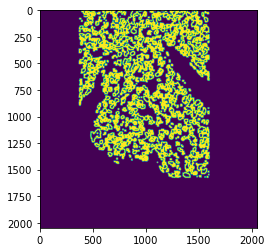

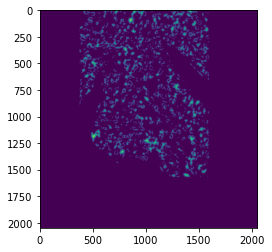

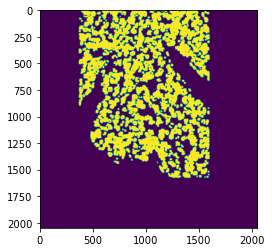

In [673]:
plt.imshow(unknown)
unknown.max()
plt.figure();plt.imshow(dist_transform)
plt.figure();plt.imshow(sure_bg)

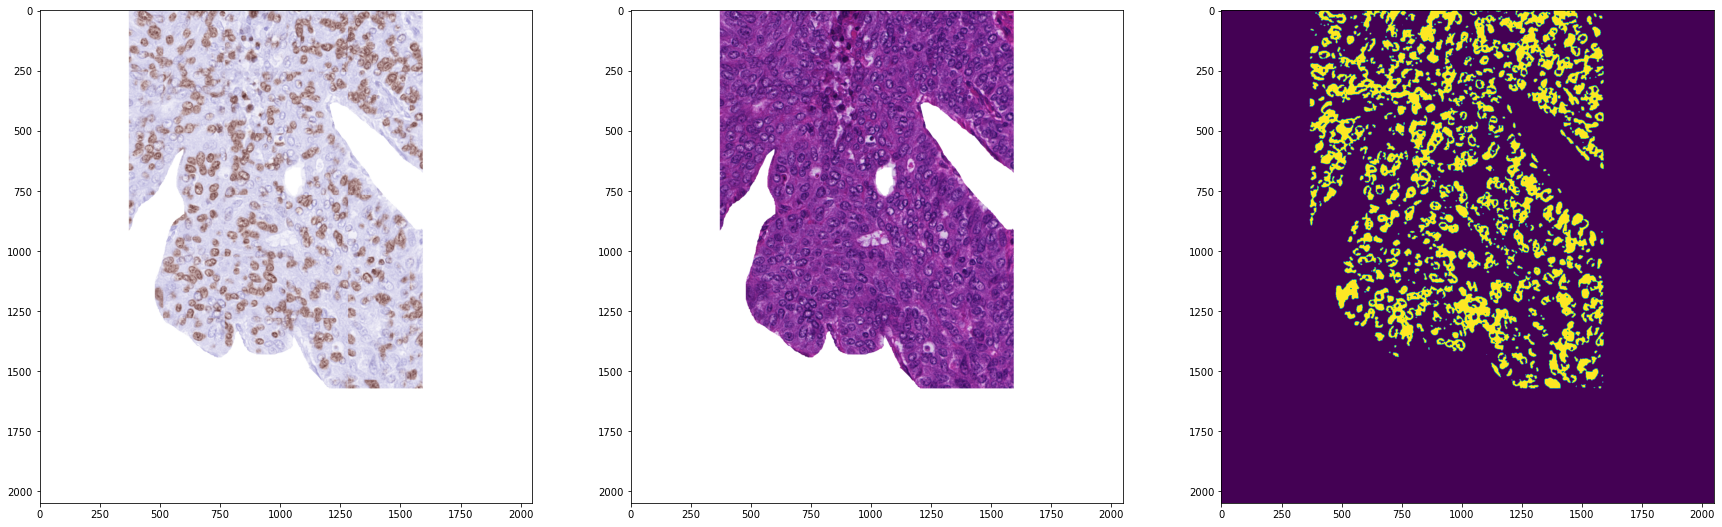

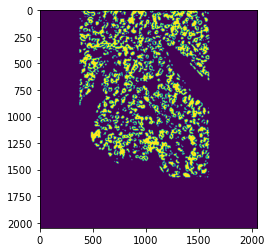

In [674]:
plt.figure(figsize=(30,10))
plt.subplot(131);plt.imshow(im_ihc)
plt.subplot(132);plt.imshow(im_he)
plt.subplot(133);plt.imshow(opening)
plt.figure();plt.imshow(im_mask)

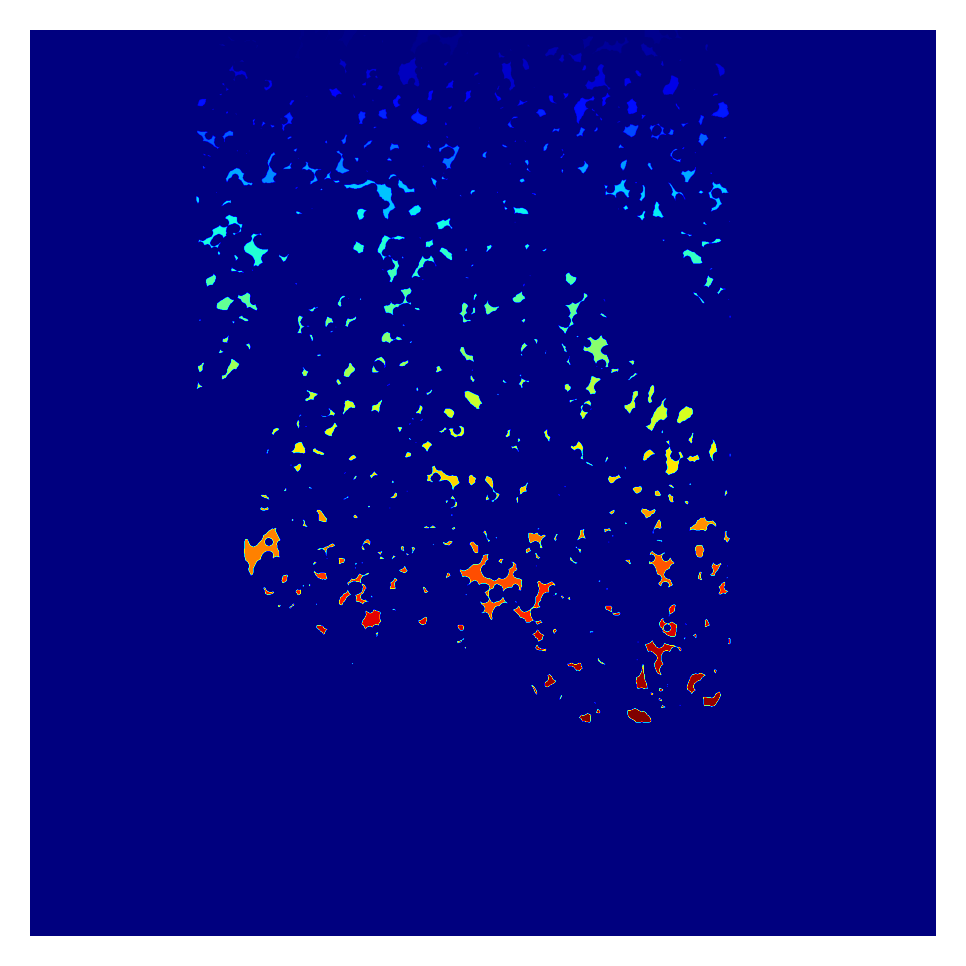

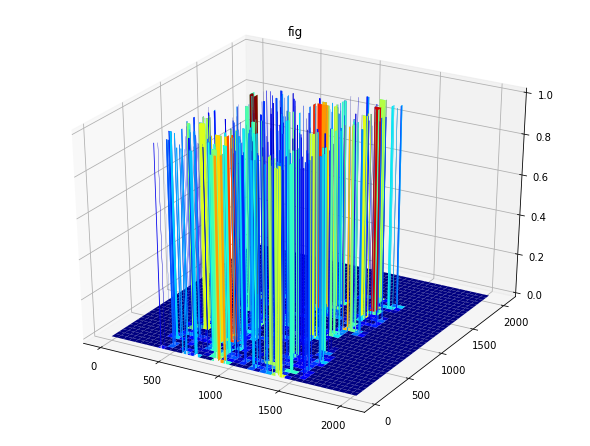

In [675]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==1] = 0

plt.figure(figsize=(4,4), dpi=300);plt.imshow(markers, cmap='jet');plt.axis("off")
surf(markers>1)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

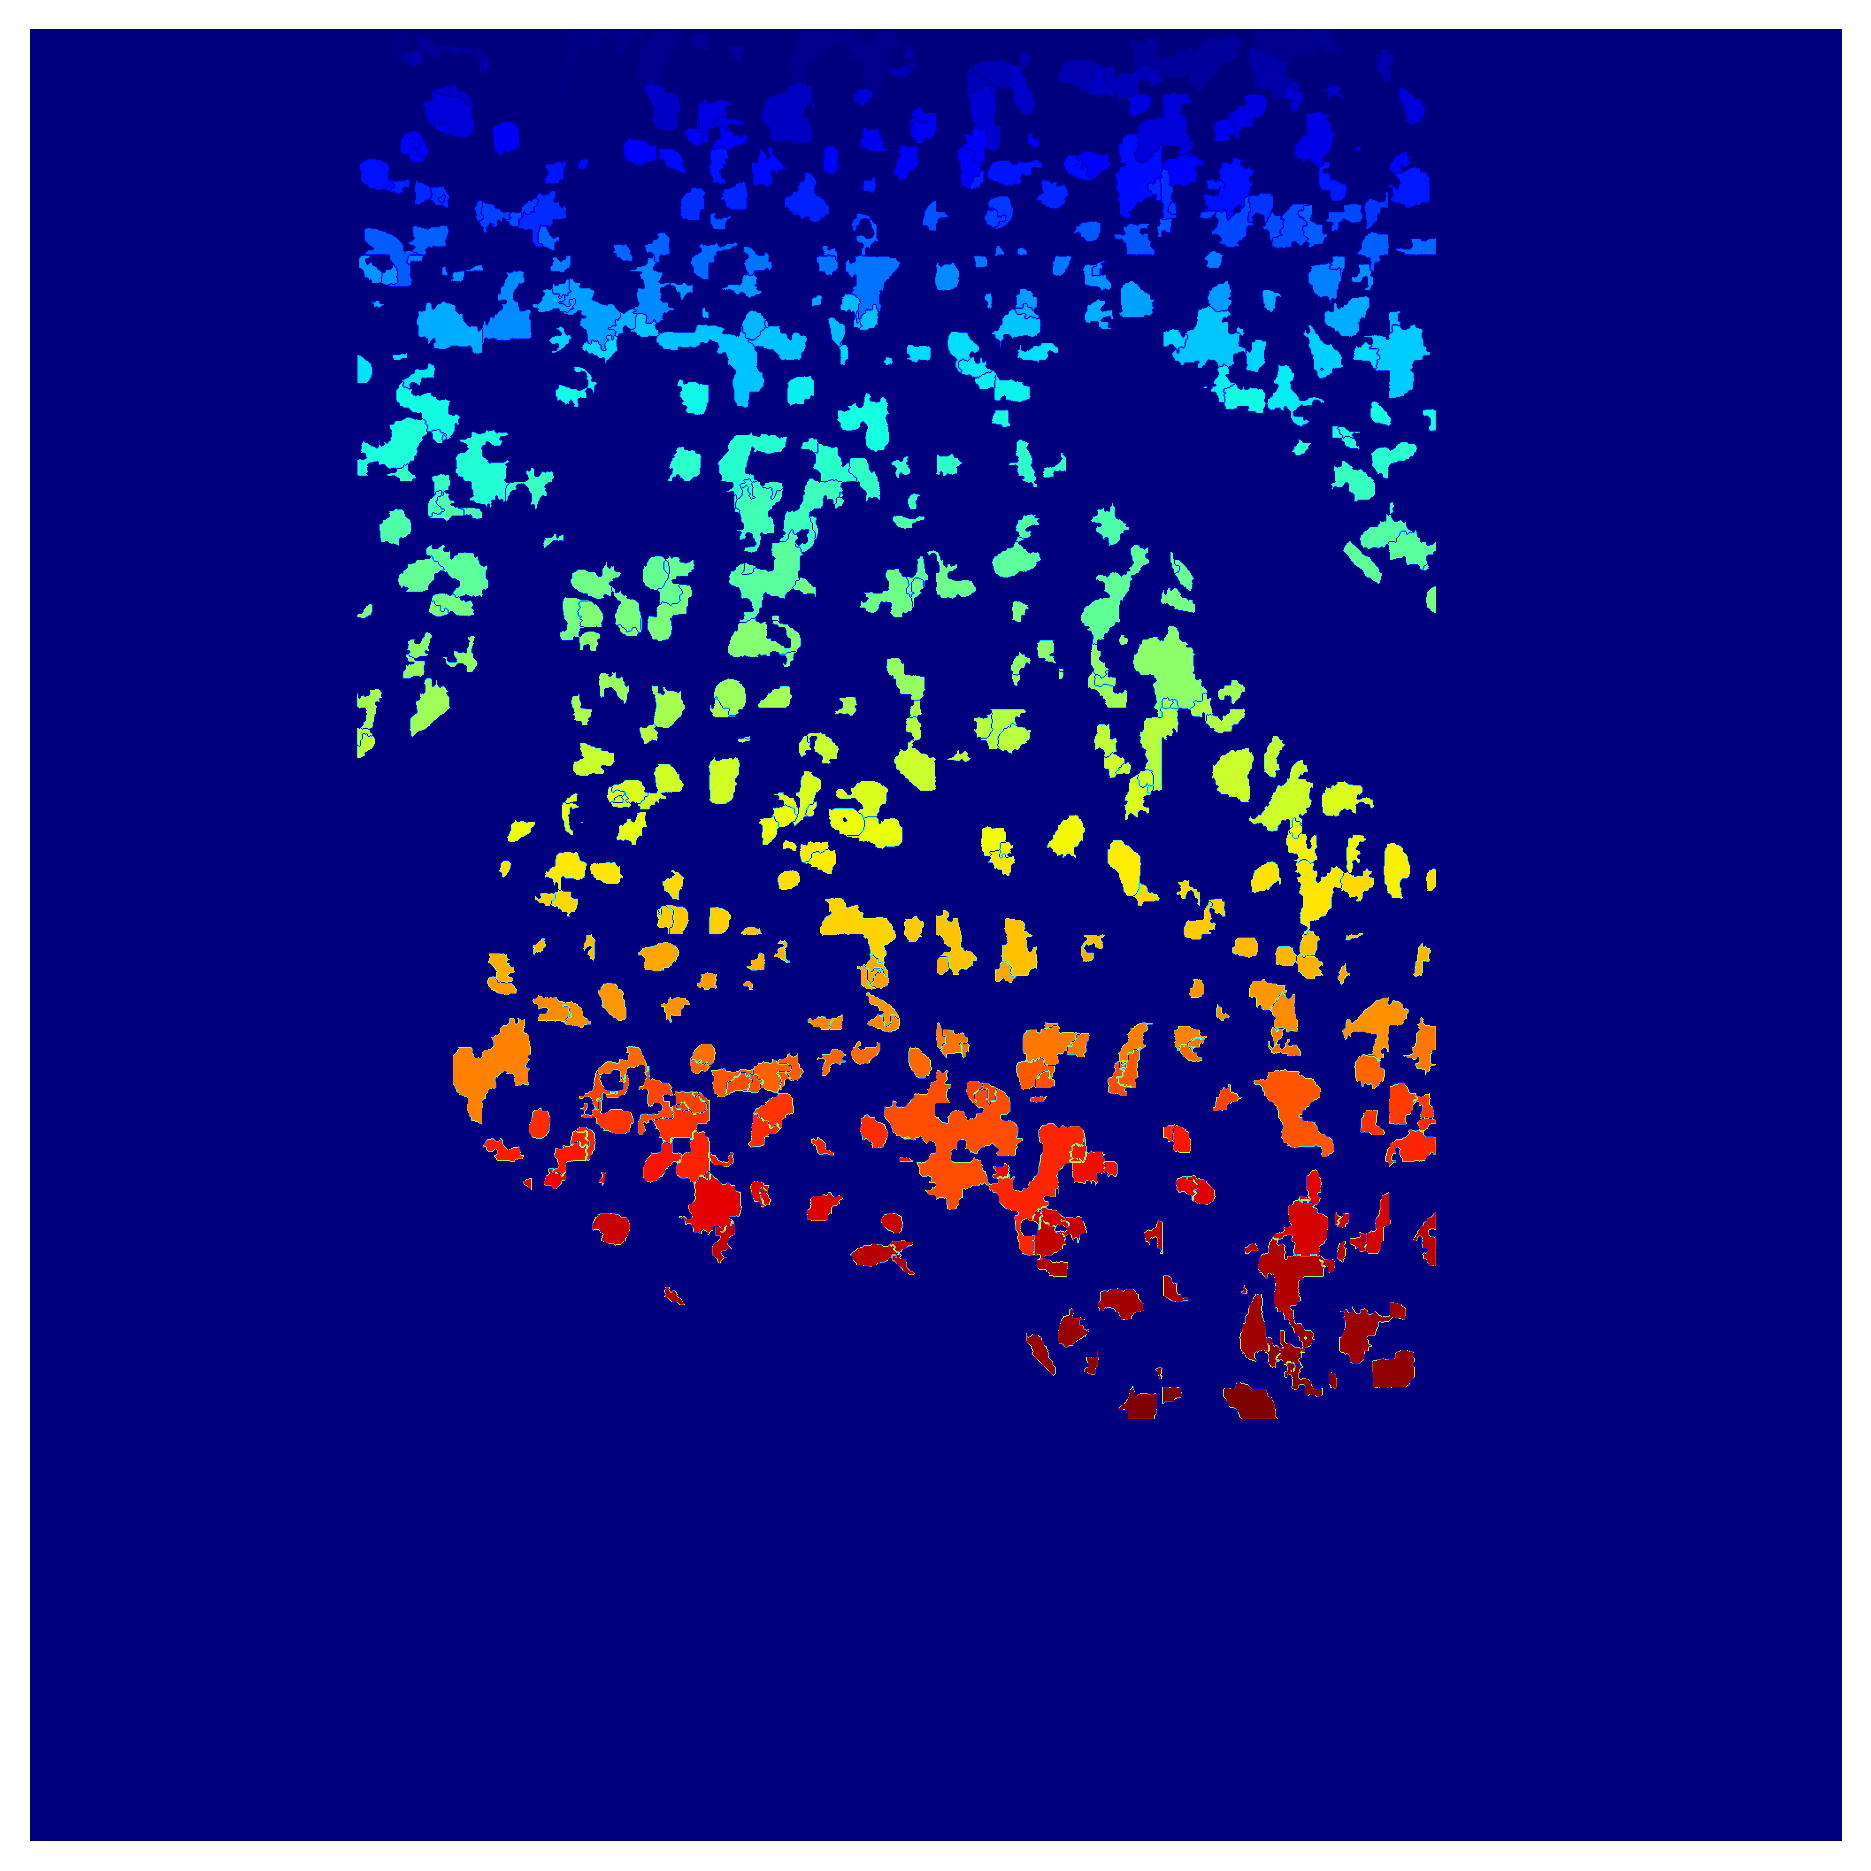

In [676]:
markers = cv.watershed(np.uint8(im_ihc*255),markers)
im_he[markers == -1] = [0,255,0]
im_ihc[markers == -1] = [0,255,0]
plt.figure(figsize=(8,8), dpi=300);plt.imshow(markers, cmap='jet');plt.axis("off")
# plt.figure(figsize=(8,4), dpi=300)
# plt.subplot(121);plt.imshow(im_he);plt.axis('off')
# plt.subplot(122);plt.imshow(im_ihc);plt.axis('off')
np.unique(markers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


761


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


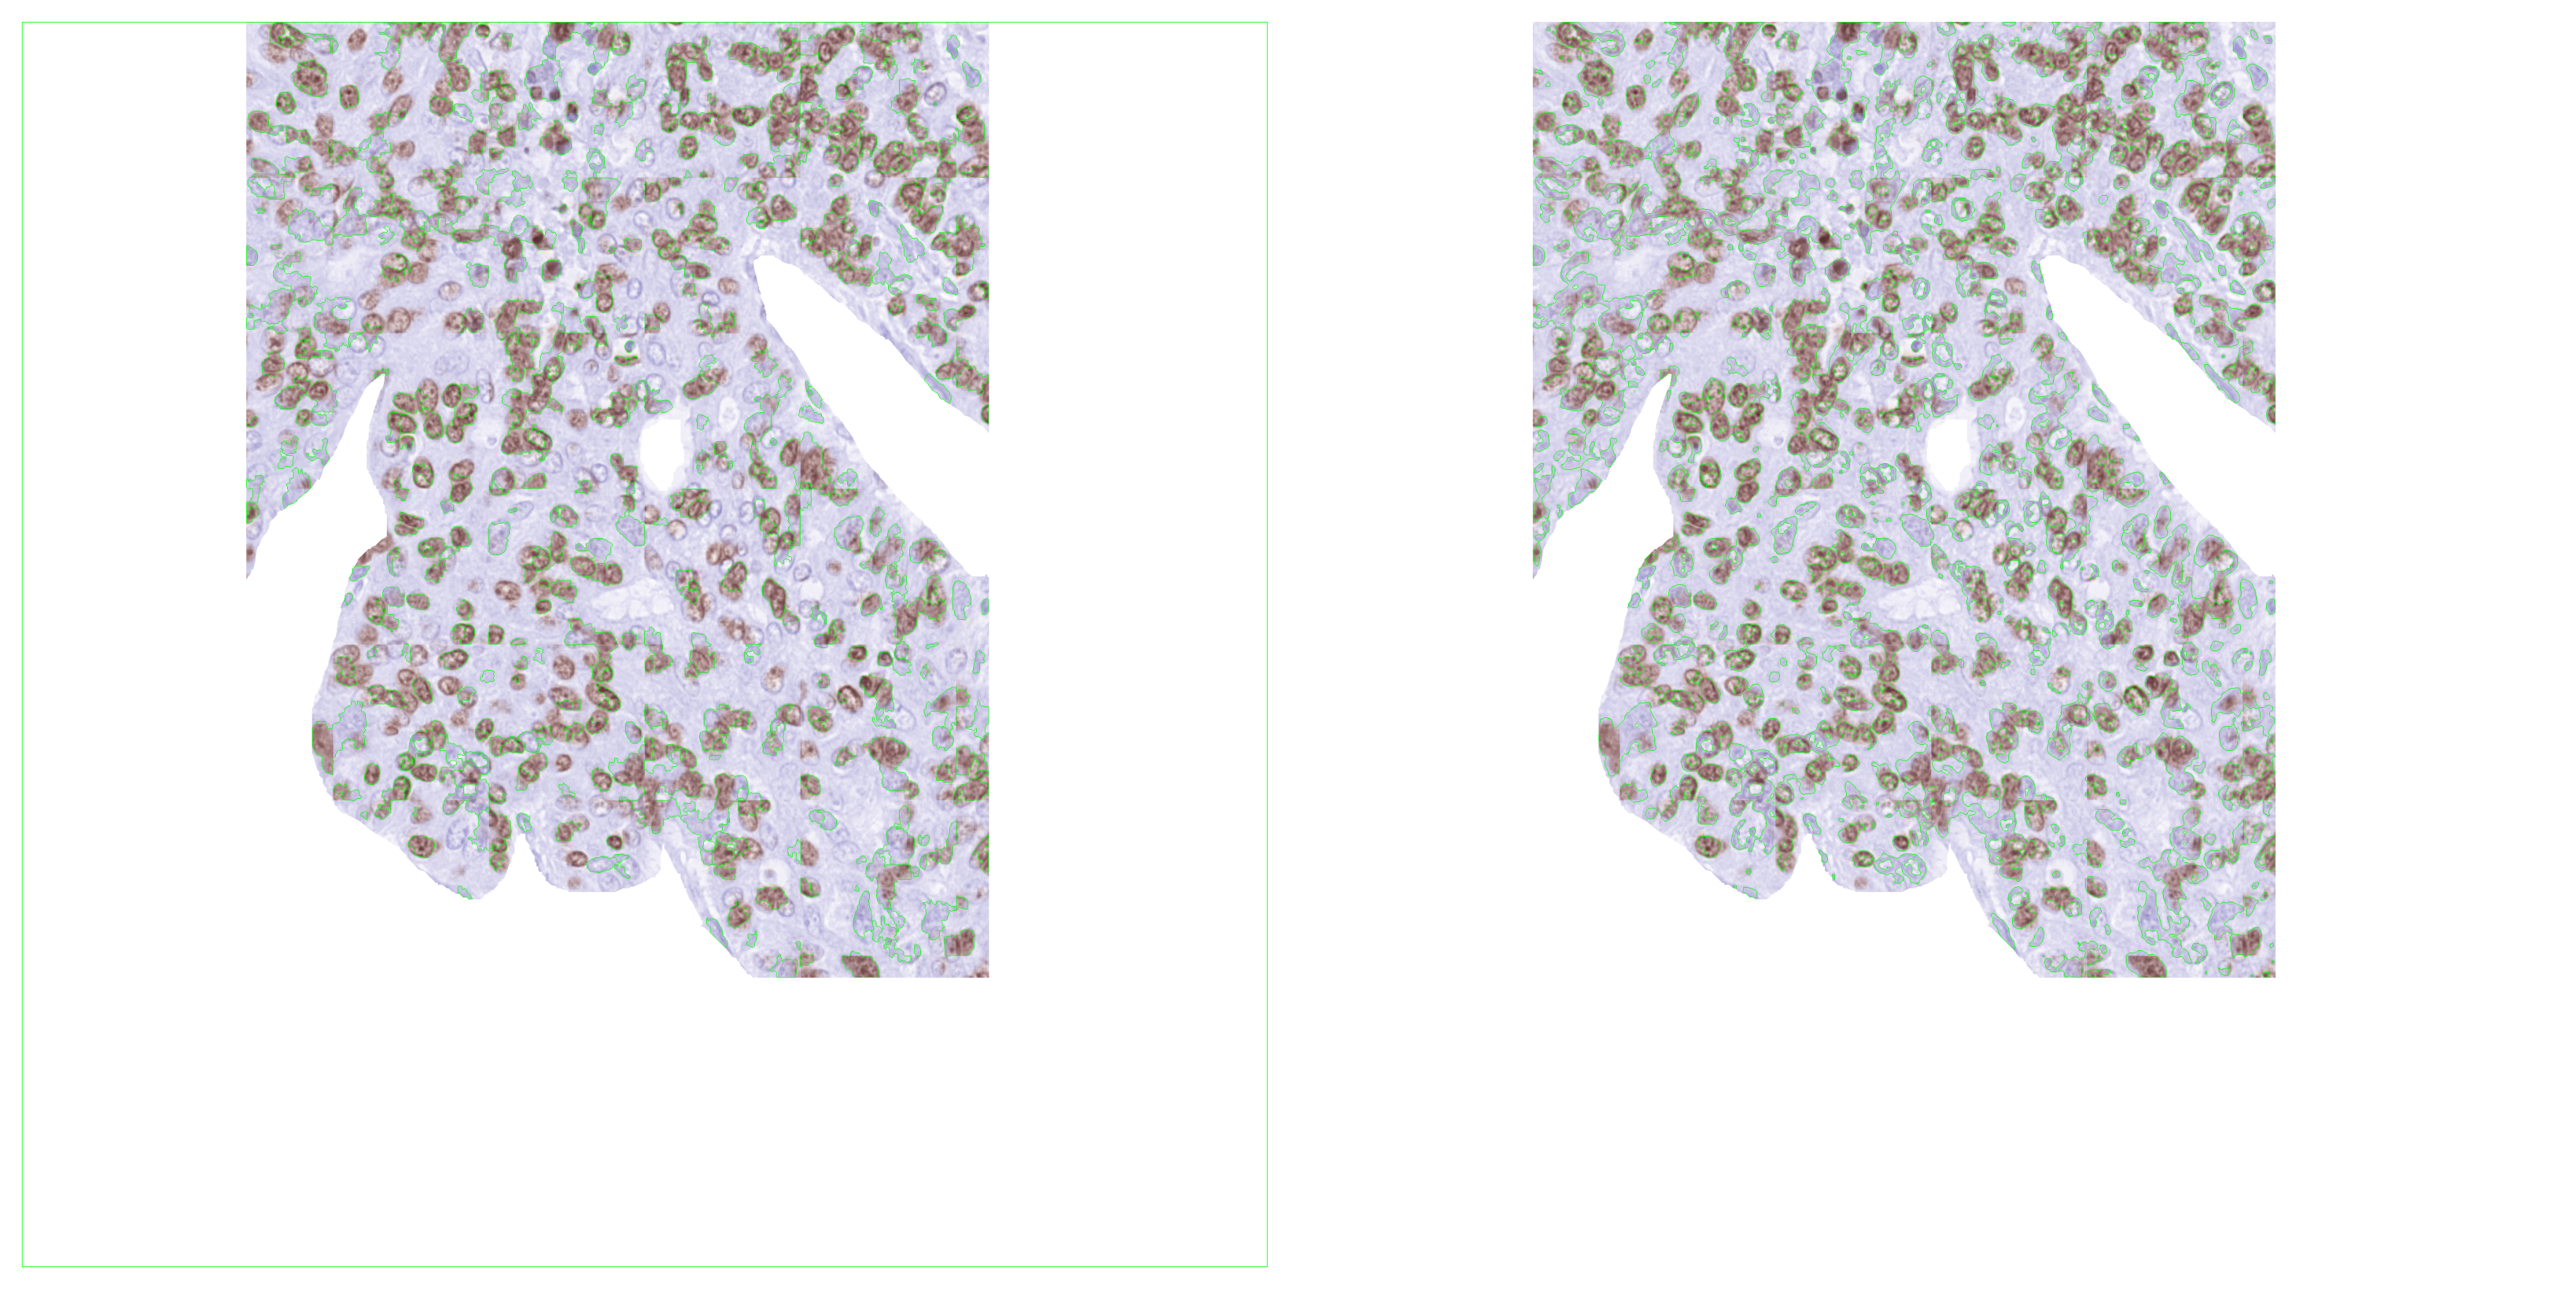

In [677]:
ret, thresh = cv.threshold(im_mask, 127, 255, 0)
contours, hierarchy = cv.findContours(im_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print(len(contours))
plt.figure(figsize=(12,6), dpi=300)
plt.subplot(121);plt.imshow(im_ihc);plt.axis('off');plt.tight_layout()
plt.subplot(122);plt.imshow(cv.drawContours(im_ki67.copy(), contours, -1, (0,255,0), 1));plt.axis('off');plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


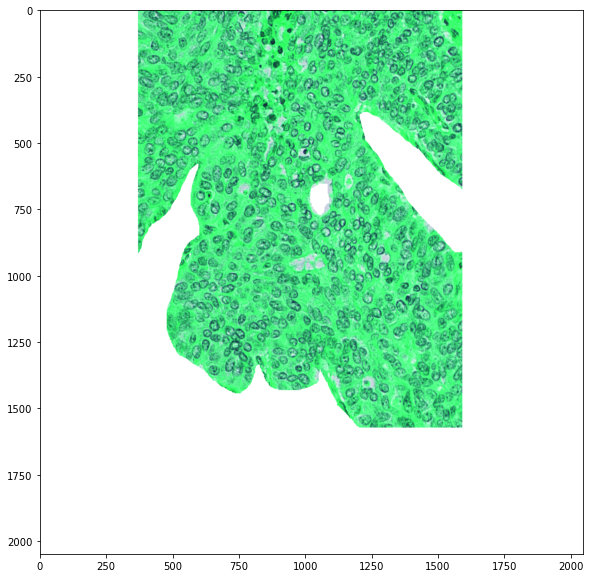

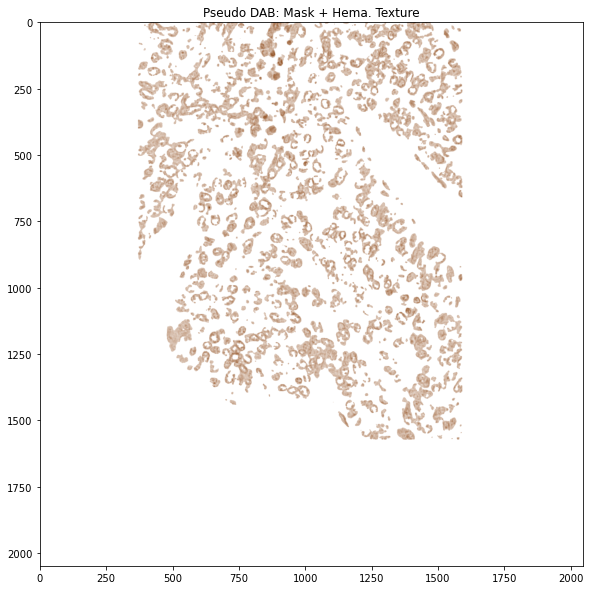

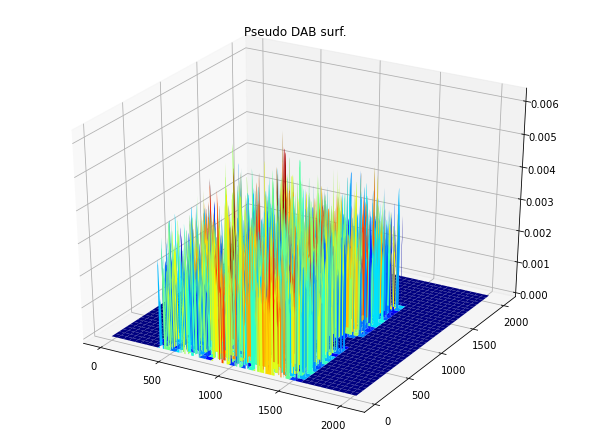

In [678]:
imci=abs(hecconv(im_sepa_hex, H))
plt.figure(figsize = (10,10));
plt.imshow(imci)

plt.figure(figsize = (10,10));
hmod = (abs(im_sepa_hex[:,:,0]))*im_mask/255
plt.imshow(hmod, cmap=cmap_dab); plt.title("Pseudo DAB: Mask + Hema. Texture")

surf(hmod, "Pseudo DAB surf.", div=(50,50))

## 实验：ki67染色解组及重组

(2048, 2048, 3)
(4194304, 3)


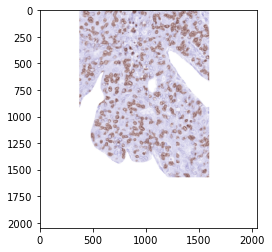

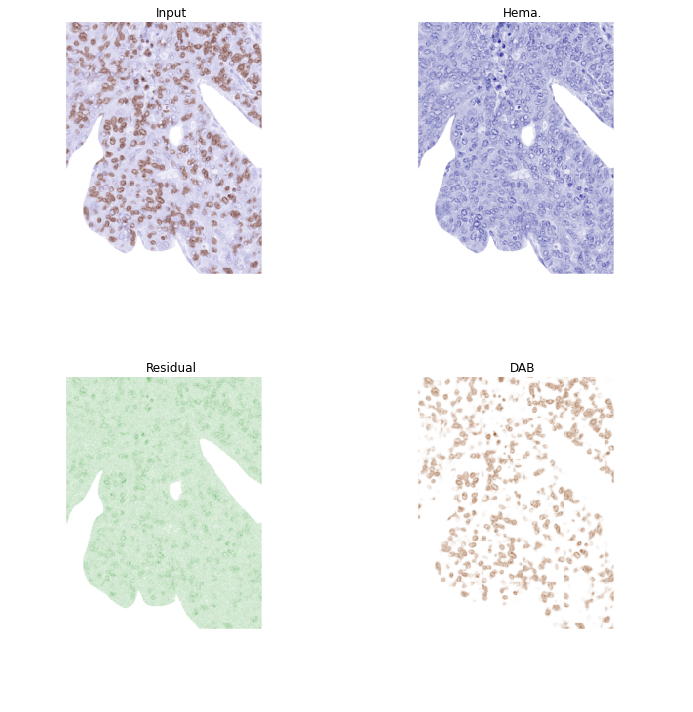

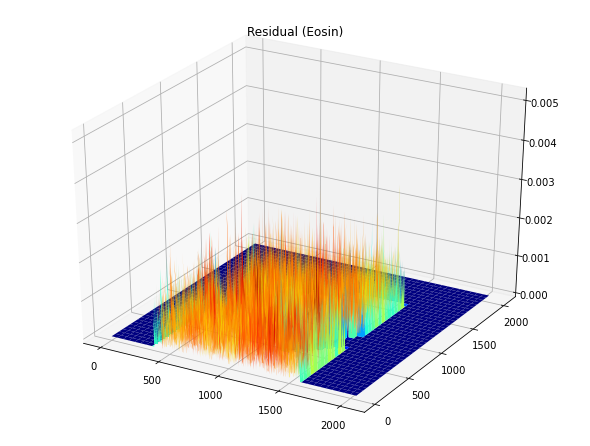

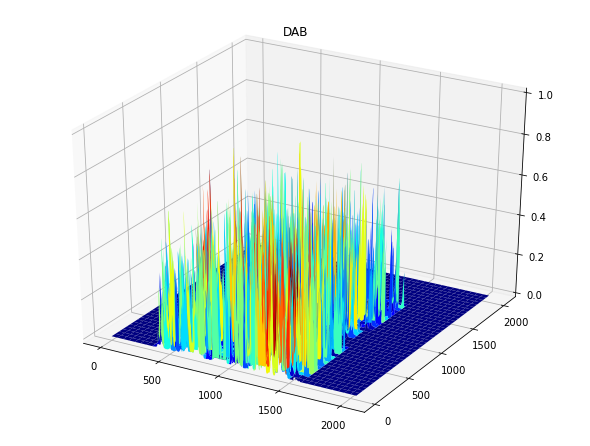

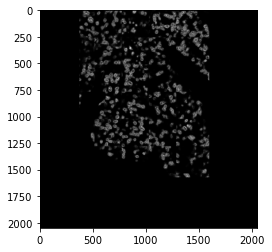

In [656]:
H = H_ki67
Hinv = linalg.inv(norm_by_row(H))
plt.figure();plt.imshow(im_ki67)
img = np.float32(im_ki67)
img[img==0] = 1E-6
im_sepa_ki67=abs(rgbdeconv(img, Hinv))

h = im_sepa_ki67[:,:,0];e_r = im_sepa_ki67[:,:,1];d = im_sepa_ki67[:,:,2];



fig = plt.figure(figsize=(10,10));
plt.subplot(221);plt.imshow(img);plt.title("Input");plt.axis('off')
plt.subplot(222);plt.imshow(rescale_intensity(h, in_range=in_range(h)), cmap=cmap_hema);plt.title("Hema.");plt.axis('off')
plt.subplot(223);plt.imshow(rescale_intensity(e_r, in_range=in_range(e_r)), cmap=cmap_res);plt.title("Residual");plt.axis('off')
plt.subplot(224);plt.imshow(rescale_intensity(d, in_range=in_range(d)), cmap=cmap_dab);plt.title("DAB");plt.axis('off')
fig.tight_layout()

surf(e_r, "Residual (Eosin)")
surf(rescale_intensity(d, in_range=in_range(d)), "DAB")
d.max()
plt.imshow(rescale_intensity(d, in_range=in_range(d)), cmap="gray")

In [ ]:
h1 = rescale_intensity(h, in_range=in_range(h))
d1 = rescale_intensity(d, in_range=in_range(d))
plt.figure(figsize=(10,10));plt.imshow(d1, cmap=cmap_dab);plt.axis('off')
plt.figure(figsize=(10,10));plt.imshow(d1>0.7, cmap="gray")
plt.figure(figsize=(10,10));plt.imshow(d1>0.5, cmap="gray")
plt.figure(figsize=(10,10));plt.imshow(d1>0.1, cmap="gray")
plt.figure(figsize=(10,10));plt.imshow(d1>0.05, cmap="gray")
plt.figure(figsize=(10,10));plt.imshow(h1>0.1, cmap="gray")
dmask = d1>0.05

## 引导滤波

In [ ]:
from cv2 import ximgproc

d2 = (d1*255).astype(uint8)

guide = d2

geps = 1000; grad=5
guidedDAB = ximgproc.guidedFilter(guide=guide, src=d2, radius=grad, eps=geps, dDepth=-1)
gd = ximgproc.guidedFilter(guide=guide, src=d2, radius=grad, eps=geps, dDepth=-1)
gd = rescale_intensity(gd, in_range=in_range(gd))

fig = plt.figure(figsize=(20,20))
axis = plt.subplot(1, 2, 2)
axis.imshow(gd, cmap=cmap_dab)
axis.set_title("Guided Filter Applied. Radius=%d, Eps=%d"%(grad, geps))
axis.axis('off')

axis = plt.subplot(1,2,1)
axis.imshow(d1, cmap=cmap_dab)
axis.set_title("Orignal DAB")
axis.axis('off')
plt.tight_layout()
plt.show()

guidedDAB = d2
plt.figure(figsize=(10,10));surf(gd)
_,dmask = cv.threshold((guidedDAB*255).astype(uint8),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

guidedDAB = ((255-dmask) > 0).astype(uint8)
plt.figure(figsize=(20,10));plt.subplot(121);plt.imshow(guidedDAB, cmap = "gray");plt.axis('off');plt.title("Thresh")

MOP_SIZE, MCL_SIZE = 7, 9
guidedDAB = cv.morphologyEx(guidedDAB, op=cv.MORPH_OPEN, kernel=np.ones((MOP_SIZE,MOP_SIZE), uint8))
# guidedDAB = cv.morphologyEx(guidedDAB, op=cv.MORPH_CLOSE, kernel=np.ones((MCL_SIZE, MCL_SIZE), uint8))

plt.figure(figsize=(10,10));plt.imshow(guidedDAB, cmap = "gray");plt.axis('off');plt.title("MORPH proc")

im_mask = guidedDAB
plt.figure(figsize = (10,10));
hmod = (abs(im_sepa_hex[:,:,0]))*im_mask
plt.imshow(hmod, cmap=cmap_dab); plt.title("Pseudo DAB: Mask + Hema. Texture")
surf(hmod, "Pseudo DAB surf.", div=(50,50))

In [ ]:
imci=hecconv(im_sepa_ki67, H)
plt.figure(figsize=(10,10));plt.imshow(imci)

In [ ]:
thresh = np.expand_dims(im_mask.astype(np.uint8), -1)

im_he = cv.cvtColor(im_hex, cv.COLOR_BGR2RGB).astype(np.uint8)
im_ihc = cv.cvtColor(im_ki67, cv.COLOR_BGR2RGB).astype(np.uint8)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 5)

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=10)

# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,3)
ret, sure_fg = cv.threshold(dist_transform,0.5*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)


plt.figure(figsize=(30,10))
plt.subplot(131);plt.imshow(im_ihc)
plt.subplot(132);plt.imshow(im_he)
plt.subplot(133);plt.imshow(opening)

In [ ]:
plt.imshow(dist_transform, cmap="gray");plt.axis('off')

In [ ]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.figure(figsize=(10,10));plt.imshow(markers, cmap='jet')

In [ ]:
markers = cv.watershed(im_he,markers)
im_he[markers == -1] = [0,255,0]
im_ihc[markers == -1] = [0,255,0]
plt.imshow(markers>1)

In [ ]:
plt.figure(figsize=(40,20))
plt.subplot(121);plt.imshow(im_he);plt.axis('off')
plt.subplot(122);plt.imshow(im_ihc);plt.axis('off')

In [ ]:
plt.figure(figsize=(10,10));plt.imshow(markers);plt.axis('off')

## 实验：染色浓度调整

In [ ]:
from skimage.exposure import rescale_intensity

# Rescale hematoxylin and DAB signals and give them a fluorescence look


stain_scale_factor = np.array([0.8, 0.05, 0.5]).T # to adjust the instensity of dab in pseudo image

im_sepa_hex[np.where(im_sepa_hex==inf)] = 0
h = im_sepa_hex[:, :, 0] # hema.
r = im_sepa_hex[:, :, 1] # residual. (no eosin applied)

zdh = np.dstack((h, r, hmod))

zdh = (zdh.reshape(-1,3)*stain_scale_factor).reshape(im_sepa_hex.shape)

fig = plt.figure(figsize=(20,20))
axis = plt.subplot(1, 2, 1)
axis.imshow(hecconv(zdh, H))
axis.set_title("Pseudo Hematoxylin-DAB")
axis.axis('off')

axis = plt.subplot(1,2,2)
axis.imshow(img)
axis.set_title("True Hematoxylin-DAB")
axis.axis('off')
plt.tight_layout()
plt.show()

## 实验：染色浓度配准

In [ ]:
def reject_outliers(data, m=3):
    dt = data.copy()
    dt[(abs(data - np.mean(data)) > m * np.std(data))] = np.mean(data)
    return dt

h3 = reject_outliers(h)
d3 = reject_outliers(d)

h1 = rescale_intensity(reject_outliers(h), 
                       in_range=in_range(reject_outliers(h)))
d1 = rescale_intensity(d, in_range(reject_outliers(d)))
plt.imshow(h3, cmap=cmap_hema)
plt.figure();plt.imshow(d1, cmap=cmap_dab)
plt.figure();plt.imshow(d3, cmap=cmap_dab)
surf(h1, "Rescl. H")
surf(guidedDAB*d1, "Rescl. D")
plt.figure(); plt.hist(d1.reshape(-1,), 50)
plt.figure(); plt.hist((d1[d1>0.1]).reshape(-1,), 50)
plt.figure(); plt.hist(d3.reshape(-1,), 50)
plt.figure(); plt.hist((gd/255).reshape(-1,), 50)

plt.figure(); plt.hist(h.reshape(-1,), 50)
plt.figure(); plt.hist(h3.reshape(-1,), 50)

In [ ]:
plt.figure(figsize=(10,10))
lbl = np.dstack([h1,  guidedDAB*d1, zeros_like(h1),])
lbl = np.dstack([h1,  e_r, guidedDAB*d1])
lbl_toshow = lbl
plt.imshow(lbl_toshow)
plt.axis('off')
h.max()
plt.figure();plt.hist(h.reshape(-1,), 50)
plt.figure();plt.hist(d.reshape(-1,), 50)
plt.imsave("lb.png", lbl_toshow)
lbl = np.dstack([h,  e_r, d])

## 蒙板阈值测试

In [ ]:
from PIL import Image
im = Image.open("./lb.png");im

In [ ]:
recover_ki67 = hecconv(lbl, H_ki67)
plt.imshow(recover_ki67);plt.axis('off')

In [ ]:
surf(h1)

In [ ]:
surf(d1)

In [ ]:
goupi = cv.cvtColor(cv.imread("/Users/cunyuan/DATA/Kimura/qupath-proj/tiles/Label_256/1506_01_17-7930_Ki67_IHC (d=1.0, x=29968.0, y=86384.0, w=256.0, h=256.0, z= 1506).png", cv.CV_32F), cv.COLOR_BGR2GRAY)

In [ ]:
goupi.shape

In [ ]:
surf(goupi)

In [ ]:
np.unique(goupi.reshape(-1))

In [ ]:
g3 = [1018,
984,
931,
841,
692,
517,
311,
114,
15]
_4d = [1057,
921,
734,
202,
1,
0,
0,
0,
0]
th = [0.01,
0.02,
0.04,
0.09,
0.16,
0.25,
0.36,
0.49,
0.64
]
_4d = np.

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(th, g3, th, _4d)
plt.grid()
plt.xlabel("Threshold")
plt.ylabel("# of tiles")